# DIVAnd full analysis

This notebook presents the different steps necessary for the creation of a climatology:
1. ODV data reading.
2. Extraction of bathymetry and creation of mask
3. Data download from other sources and duplicate removal.
4. Quality control.
5. Parameter optimisation.
6. Spatio-temporal interpolation with `DIVAnd`.

In [49]:
using NCDatasets
using PhysOcean
using DataStructures
using DIVAnd
using PyPlot
using Dates
using Statistics
using Random
using Printf


This notebook uses the module DIVAnd 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.1466985.svg)](https://doi.org/10.5281/zenodo.1466985)

## Configuration
* Define the horizontal, vertical and temporal resolutions.
* Select the variable

In [50]:
dx, dy = 0.125, 0.125
lonr = 11.5:dx:20
latr = 39:dy:46
timerange = [Date(1950,1,1),Date(2017,12,31)];

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
depthr = [0.,10.,20.];

In [51]:
varname = "Salinity"
yearlist = [1900:2017];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];

In [52]:
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
@show TS;

TS = TimeSelectorYearListMonthList{Array{UnitRange{Int64},1},Array{Array{Int64,1},1}}(UnitRange{Int64}[1900:2017], Array{Int64,1}[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])


## 1. Read your ODV file
Adapt the `datadir` and `datafile` values.     
The example is based on a sub-setting of the [Mediterranean Sea](https://www.seadatanet.org/Products#/metadata/cd552057-b604-4004-b838-a4f73cc98fcf) aggregated dataset.
<img src="./Images/MedSeaAggreg.jpg" width="450px">

In [53]:
datadir = "./Adriatic/"
smalldatafile = joinpath(datadir, "AdriaticSea_SDC_1000.txt")
datafile = joinpath(datadir, "AdriaticSea_SDC.txt")
if !isdir(datadir)
    @info("Creating data directory")
    mkdir(datadir) 
end

Download the data files (test and full) if needed.

In [54]:
if !isfile(smalldatafile)
    @info("Downloading test data file (1000 lines)")
    download("https://dox.ulg.ac.be/index.php/s/FtJdbLDk11buP47/download", smalldatafile)
else
    @info("Data file already downloaded")
end

if !isfile(datafile)
    @info("Downloading data file")
    download("https://dox.ulg.ac.be/index.php/s/A4Eu9nEoovYLtGr/download", datafile)
else
    @info("Data file already downloaded")
end

┌ Info: Data file already downloaded
└ @ Main In[54]:5
┌ Info: Data file already downloaded
└ @ Main In[54]:12


⌛⌛    
Depending on the size of your file, this step can take up to a few minutes.     
You can try and test first on the small file, this should take less than 10 seconds (the 1st time).

In [55]:
@time obsval,obslon,obslat,obsdepth,obstime,obsid = ODVspreadsheet.load(Float64,[smalldatafile],
                           ["Water body salinity"]; nametype = :localname );

┌ Info: Reading data from file ./Adriatic/AdriaticSea_SDC_1000.txt
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:76
┌ Info: No. of profiles in the file: 79
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:253
┌ Info: Working on variable Water body salinity
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:777
┌ Info: Starting loop on the 79 profiles
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:794


  0.173300 seconds (757.79 k allocations: 39.694 MiB)


┌ Info: Done reading the profiles
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:836


In [56]:
@time obsval,obslon,obslat,obsdepth,obstime,obsid = ODVspreadsheet.load(Float64,[datafile],
                           ["Water body salinity"]; nametype = :localname );

┌ Info: Reading data from file ./Adriatic/AdriaticSea_SDC.txt
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:76
┌ Info: No. of profiles in the file: 34709
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:253
┌ Info: Working on variable Water body salinity
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:777
┌ Info: Starting loop on the 34709 profiles
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:794


188.484924 seconds (833.40 M allocations: 41.245 GiB, 42.42% gc time)


┌ Info: Done reading the profiles
└ @ DIVAnd.ODVspreadsheet /home/abarth/projects/Julia/DIVAnd.jl/src/ODVspreadsheet.jl:836


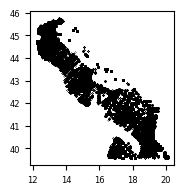

In [57]:
figure("Adriatic-Data", figsize=(2,2))
ax = subplot(1,1,1)
plot(obslon, obslat, "ko", markersize=.1)
aspect_ratio = 1/cos(mean(latr) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspect_ratio)

Check the extremal values of the observations

In [58]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/obsstat.jl:75


12.25017, 20.11)
              minimum and maximum of obs. dimension 2: (39.55676, 45.755)
              minimum and maximum of obs. dimension 3: (0.0, 1484.203)
              minimum and maximum of obs. dimension 4: (1911-08-17T09:24:00, 2015-02-10T10:43:00)
                          minimum and maximum of data: (4.07, 40.880001)


In [59]:
@show length(obslon);
@show length(obslat);
@show length(obsval);
@show length(obstime);
@show length(obsid);

length(obslon) = 1430741
length(obslat) = 1430741
length(obsval) = 1430741
length(obstime) = 1430741
length(obsid) = 1430741


## 2. Extract the bathymetry
It is used to delimit the domain where the interpolation is performed.

### 2.1 Choice of bathymetry
Modify `bathname` according to the resolution required.

In [60]:
bathname = "./data/gebco_30sec_8.nc"
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[60]:5


In [61]:
@time bx,by,b = load_bath(bathname,true,lonr,latr);

  0.000813 seconds (276 allocations: 223.703 KiB)


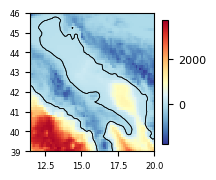

In [62]:
figure("Adriatic-Bathymetry", figsize=(2,2))
ax = subplot(1,1,1)
pcolor(bx,by,permutedims(b, [2,1]));
colorbar(orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)
contour(bx,by,permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.5)
gca().set_aspect(aspect_ratio)
ax.tick_params("both",labelsize=6)

### 2.2 Create mask
* False for sea        
* True for land

In [63]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)

size(mask) = (69, 57, 3)


(69, 57, 3)

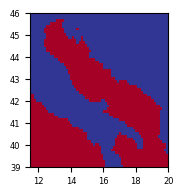

In [64]:
figure("Adriatic-Mask", figsize=(2,2))
ax = subplot(1,1,1)
gca().set_aspect(aspect_ratio)
ax.tick_params("both",labelsize=6)
pcolor(bx,by,permutedims(Float64.(mask[:,:,2]), [2,1])); 

### 2.3 Edit the mask
As an example we will remove the Mediterranean Sea from the domain.

In [65]:
grid_bx = [i for i in bx, j in by];
grid_by = [j for i in bx, j in by];

In [66]:
mask_edit = copy(mask);
sel_mask1 = (grid_by .<= 42.6) .& (grid_bx .<= 14.);
sel_mask2 = (grid_by .<= 41.2) .& (grid_bx .<= 16.2);
mask_edit = mask_edit .* .!sel_mask1 .* .!sel_mask2;
@show size(mask_edit)

size(mask_edit) = (69, 57, 3)


(69, 57, 3)

The edited mask now looks like this:

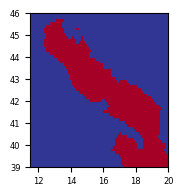

(11.5, 20.0)

In [67]:
figure("Adriatic-Mask-Edited", figsize=(2,2))
ax = subplot(1,1,1)
gca().set_aspect(aspect_ratio)
ax.tick_params("both",labelsize=6)
pcolor(bx, by, permutedims(Float64.(mask_edit[:,:,2]), [2,1])); 
gca().set_aspect(aspect_ratio)
xlim()

## 3. Extract data from other sources
As an illustration we use the World Ocean Database, among other possibilities.

### 3.1 World Ocean Database

In [68]:
# Configuration
email = "your-mail@domain"
woddatadir = "./Adriatic/WOD/"
mkpath(woddatadir);

In [69]:
# Uncomment the next line if you have to download the data
# WorldOceanDatabase.download(lonr,latr,timerange,varname,email,woddatadir);

⌛⌛         
Read the data. This can also take up to a few minutes, depending on the size of the domain.

⚠️ The WOD observations IDs have to be modified in order to be ingested by the XML generation (Step 9): to this end, we add the EDMO code of the U.S. NODC, which is 1977.

In [70]:
@time obsvalwod,obslonwod,obslatwod,obsdepthwod,obstimewod,obsidwod = 
WorldOceanDatabase.load(Float64,woddatadir,varname,prefixid = "1977-");

┌ Info: Loading files from ./Adriatic/WOD/CTD/ocldb1560025519.12915.CTD.nc
└ @ PhysOcean.WorldOceanDatabase /home/abarth/.julia/dev/PhysOcean/src/WorldOceanDatabase.jl:474
┌ Info: Loading files from ./Adriatic/WOD/GLD/ocldb1560025519.12915.GLD.nc
└ @ PhysOcean.WorldOceanDatabase /home/abarth/.julia/dev/PhysOcean/src/WorldOceanDatabase.jl:474
┌ Info: Loading files from ./Adriatic/WOD/OSD/ocldb1560025519.12915.OSD.nc
└ @ PhysOcean.WorldOceanDatabase /home/abarth/.julia/dev/PhysOcean/src/WorldOceanDatabase.jl:474
┌ Info: Loading files from ./Adriatic/WOD/PFL/ocldb1560025519.12915.PFL.nc
└ @ PhysOcean.WorldOceanDatabase /home/abarth/.julia/dev/PhysOcean/src/WorldOceanDatabase.jl:474


 12.909199 seconds (17.25 M allocations: 2.348 GiB, 24.59% gc time)


Remove the data outside Adriatic (similar to mask editing)

In [71]:
sel_data1 = (obslatwod .<= 42.6) .& (obslonwod .<= 14.);
sel_data2 = (obslatwod .<= 41.2) .& (obslonwod .<= 16.2);
ndataremove = sum((sel_data1) .| (sel_data2))
sel_data = .~((sel_data1) .| (sel_data2));

obslatwod = obslatwod[sel_data];
obslonwod = obslonwod[sel_data];
obsdepthwod = obsdepthwod[sel_data];
obstimewod = obstimewod[sel_data];
obsvalwod = obsvalwod[sel_data];
obsidwod = obsidwod[sel_data];

@info("Number of removed WOD data: $ndataremove");
obsidwod[1:5]

┌ Info: Number of removed WOD data: 219516
└ @ Main In[71]:13


5-element Array{String,1}:
 "1977-wod_007663161O"
 "1977-wod_007663161O"
 "1977-wod_007663161O"
 "1977-wod_007663161O"
 "1977-wod_007663161O"

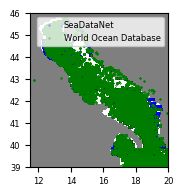

In [72]:
figure("Adriatic-WOD", figsize=(2,2))
ax = subplot(1,1,1)
ax.tick_params("both",labelsize=6)
contourf(bx, by, permutedims(Float64.(mask_edit[:,:,1]),[2,1]),
    levels=[-1e5,0],cmap="binary"); 
plot(obslon, obslat, "bo", markersize=.2, 
    label="SeaDataNet")
plot(obslonwod, obslatwod, "go", markersize=.2, 
    label="World Ocean Database");
legend(fontsize=6);
ylim(39.0, 46.0);
xlim(11.5, 20.0);
gca().set_aspect(aspect_ratio)

### 3.2 Extract from another source (optional)
Add here the code to read data from another file.

### 3.3 Remove duplicates
⌛     
Criteria (can be adapted according to the application):
* Horizontal distance: 0.01 degree (about 1km)
* Vertical separation: 0.01 m depth
* Time separation: 1 minute.      
* Salinity difference:  0.01 psu.

In [73]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
    (obslon,obslat,obsdepth,obstime), obsval, 
    (obslonwod,obslatwod, obsdepthwod, obstimewod), obsvalwod,
    (0.01,0.01,0.01,1/(24*60)),0.01);

  0.054765 seconds (48 allocations: 1.719 KiB)
  3.610795 seconds (43.05 k allocations: 3.136 GiB, 20.78% gc time)
 91.396889 seconds (18.30 M allocations: 4.207 GiB, 0.79% gc time)
 95.155234 seconds (18.34 M allocations: 7.474 GiB, 1.55% gc time)


Find the indices of the possible duplicates:

In [74]:
index = findall(.!isempty.(dupl));
ndupl = length(index);
pcdupl = round(ndupl / length(obslon) * 100; digits=2);
@info("Number of possible duplicates: $ndupl")
@info("Percentage of duplicates: $pcdupl%")

┌ Info: Number of possible duplicates: 813797
└ @ Main In[74]:4
┌ Info: Percentage of duplicates: 56.88%
└ @ Main In[74]:5


If you decide to combine the 2 (or more) datasets:

In [75]:
newpoints = isempty.(dupl);
@info("Number of new points: $(sum(newpoints)))")

┌ Info: Number of new points: 1013564)
└ @ Main In[75]:2


In [76]:
obslon = [obslon; obslonwod[newpoints]];
obslat = [obslat; obslatwod[newpoints]];
obsdepth = [obsdepth; obsdepthwod[newpoints]];
obstime = [obstime; obstimewod[newpoints]];
obsval = [obsval; obsvalwod[newpoints]];
obsid = [obsid; obsidwod[newpoints]];

Create a plot showing the additional data points:

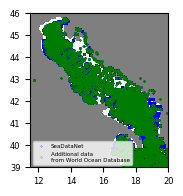

In [77]:
figure("Adriatic-Additional-Data", figsize=(2,2))
ax = subplot(1,1,1)
ax.tick_params("both",labelsize=6)
ylim(39.0, 46.0);
xlim(11.5, 20.0);
contourf(bx, by, permutedims(Float64.(mask_edit[:,:,1]),[2,1]),
    levels=[-1e5,0],cmap="binary"); 
plot(obslon, obslat, "bo", markersize=.2, label="SeaDataNet")
plot(obslonwod[newpoints], obslatwod[newpoints], "go", 
    markersize=.2, label="Additional data\nfrom World Ocean Database")
legend(loc=3, fontsize=4)
gca().set_aspect(aspect_ratio)

## 4. Quality control
We check the salinity value.     
Adapt the criteria to your region and variable.

In [78]:
sel = (obsval .<= 40) .& (obsval .>= 25);

In [79]:
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];

## 5. Analysis parameters

### Modify data weight 
⌛⌛⌛       
Compute the new weights that takes into account close points.     
If the dataset is large, this can take a few minutes.     
The maximal and mean values provide an indication of the spatial proximity between the data.    
If you apply this technique, you need to adapt `epsilon2`:

In [80]:
#@time rdiag=1.0./DIVAnd.weight_RtimesOne((obslon,obslat),(0.03,0.03));
#@show maximum(rdiag),mean(rdiag)

### Correlation lengths and noise-to-signal ratio
We will use the function `diva3D` for the calculations.     
With this function, the correlation length has to be defined in meters, not in degrees.

In [81]:
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(100_000.,sz)   # 100 km
leny = fill(100_000.,sz)   # 100 km
lenz = fill(25.,sz);      # 25 m 
len = (lenx, leny, lenz);
epsilon2 = 0.1;
#epsilon2 = epsilon2 * rdiag;

### Output file name

In [82]:
filename = "Water_body_$(replace(varname," "=>"_"))_Adriatic.4Danl.nc"

"Water_body_Salinity_Adriatic.4Danl.nc"

## 6. Metadata and attributes
Edit the different fields according to the project, the authors etc.     
This is used for the netCDF file but also for the XML needed for the Sextant catalog.

In [83]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet and World Ocean Atlas",

    # Additional comment
    "comment" => "Duplicate removal applied to the merged dataset",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",
    
    "product_code" => "something-to-decide",
    
    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # https://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    # 
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/
        
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_salinity",

    "netcdf_long_name" => "sea water salinity",

    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "https://doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...");

SeaDataNet global attributes:

In [84]:
ncglobalattrib,ncvarattrib = SDNMetadata(metadata,filename,varname,lonr,latr)

(OrderedDict("project" => "SeaDataCloud","institution" => "University of Liege, GeoHydrodynamics and Environment Research","institution_urn" => "SDN:EDMO::1579","Author_e-mail" => "Your Name1 <name1@example.com>, Other Name <name2@example.com>","source" => "observational data from SeaDataNet and World Ocean Atlas","comment" => "Duplicate removal applied to the merged dataset","parameter_keyword" => "Water body salinity","parameter_keyword_urn" => "SDN:P35::EPC00001","search_keywords" => "Salinity of the water column","search_keywords_urn" => "SDN:P02::PSAL"…), OrderedDict("units" => "1e-3","standard_name" => "sea_water_salinity","long_name" => "sea water salinity"))

## 7. Analysis

Remove the result file before running the analysis, otherwise you'll get the message     
```julia
NCDatasets.NetCDFError(13, "Permission denied")
```

In [85]:
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

┌ Info: Removing file Water_body_Salinity_Adriatic.4Danl.nc
└ @ Main In[85]:3


### 7.1 Plotting function
Define a plotting function that will be applied for each time index and depth level.     
All the figures will be saved in a selected directory.

In [86]:
figdir = "./Adriatic/figures/"
if ~(isdir(figdir))
    mkdir(figdir)
else
    @info("Figure directory already exists")
end

┌ Info: Figure directory already exists
└ @ Main In[86]:5


In [87]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        figure("Adriatic-Additional-Data", figsize=(2,2))
        ax = subplot(1,1,1)
        ax.tick_params("both",labelsize=6)
        ylim(39.0, 46.0);
        xlim(11.5, 20.0);
        title("Depth: $(depthr[i]) \n Time index: $(timeindex)", fontsize=6)
        pcolor(lonr.-dx/2.,latr.-dy/2, permutedims(tmp[:,:,i], [2,1]);
               vmin = 33, vmax = 40)
        colorbar(extend="both", orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)

        contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
        gca().set_aspect(aspect_ratio)
        
        figname = varname * @sprintf("_%02d",i) * @sprintf("_%03d.png",timeindex)
        PyPlot.savefig(joinpath(figdir, figname), dpi=600, bbox_inches="tight");
        PyPlot.close_figs()
    end
end

plotres (generic function with 1 method)

### 7.2 Create the gridded fields using `diva3d`
Here only the noise-to-signal ratio is estimated.     
Set `fitcorrlen` to `true` to also optimise the correlation length.

In [88]:
@time dbinfo = diva3d((lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime), obsval,
    len, epsilon2,
    filename,varname,
    bathname=bathname,
    plotres = plotres,
    mask = mask_edit,
    fitcorrlen = false,
    niter_e = 2,
    ncvarattrib = ncvarattrib,
    ncglobalattrib = ncglobalattrib,
    surfextend = true
    );

┌ Info: Creating netCDF file
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:329
┌ Info: Time step 1 / 4
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:381
┌ Info: scaled correlation length (min,max) in dimension 1: (100000.0, 100000.0)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:566
┌ Info: scaled correlation length (min,max) in dimension 2: (100000.0, 100000.0)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:566
┌ Info: scaled correlation length (min,max) in dimension 3: (25.0, 25.0)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:566
┌ Info: number of windows: 1
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/DIVAndgo.jl:111
┌ Info: number of windows: 1
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/DIVAndgo.jl:111
┌ Info: Time step 2 / 4
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/diva.jl:381
┌ Info: scaled correlation length (min,max) in dimension 1: (100000.0, 100000.0)
└ @ DIVAnd /home/abar

  9.298844 seconds (346.84 k allocations: 5.237 GiB, 4.02% gc time)


Example of results: salinity at 20 meters for the April-May-June period.

<img src="./Adriatic/figures/Salinity_02_002.png" width="450px">

Save the observation metadata in the NetCDF file.      

In [89]:
DIVAnd.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsid);

## 8. Apply a posteriori quality control
We can use the structure `dbinfo`.
histogram for quality flags

## 9. XML metadata

For DIVAnd analysis using SeaDataCloud/EMODnet-Chemistry data, one can create a XML description for the product for Sextant

Name of the project:
* "SeaDataCloud" or 
* "EMODNET-chemistry"

In [90]:
project = "SeaDataCloud";
project = "EMODNET-chemistry"

"EMODNET-chemistry"

Download CDI list

In [91]:
cdilist = "CDI-list-export.zip"

if !isfile(cdilist)
   download("http://emodnet-chemistry.maris2.nl/download/export.zip",cdilist)
end

If `ignore_errors` is `false` (default), then a missing CDI will stop the creatation of the XML metadata.

In [92]:
ignore_errors = true

# File name based on the variable (but all spaces are replaced by underscores)
xmlfilename = "Water_body_$(replace(varname," "=>"_")).4Danl.xml"

"Water_body_Salinity.4Danl.xml"

Uncomment the following line of you are using SeaDataCloud or EMODnet-Chemistry data.

In [93]:
# generate a XML file for Sextant catalog
divadoxml(filename,varname,project,cdilist,xmlfilename,
          ignore_errors = ignore_errors)

┌ Info: Loading EDMO information
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/SDNMetadata.jl:818
┌ Info: Lookup obsids
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/SDNMetadata.jl:324
┌ Info: Query EDMO database
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/SDNMetadata.jl:366
┌ Info: originator: Università degli Studi di Napoli 'Parthenope' - Istituto di Meteorologia e Oceanografia
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/SDNMetadata.jl:374
┌ Info: originator: Italian Hydrographic Institute
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/SDNMetadata.jl:374
┌ Info: originator: P.P.Shirshov Institute of Oceanology, RAS
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/SDNMetadata.jl:374
┌ Info: originator: CNR, Institute of Marine Sciences S.S. of Lerici (SP)
└ @ DIVAnd /home/abarth/projects/Julia/DIVAnd.jl/src/SDNMetadata.jl:374
┌ Info: originator: CNR, Istituto per lo Studio della Dinamica delle Grandi Masse
└ @ DIVAnd /home/abarth/projects/Jul